# Data Scientist Take-home Challenge


This document contains list of the tasks we would like you to complete in order to evaluate fully your technical abilities. However, if by some reason you cannot get all results in full, don’t worry. The purpose of this exercise is not to get exact numbers, but to understand how you would approach similar assignments, what would be your way of thinking and how you would advise your Client at the end.


You are to work in three separate tasks. Each requires some data handling, modelling and visualizations. We would like to get following outputs from your side:

- All the pseudo-code / code from your software of preference. Please don’t forget to include notes and comments within.
- Numerical outputs of the final models and statistical calculations (if applicable for the specific task)
- Any visualizations of the data you consider useful to support your work (interactive charts would be considered as an advantage)


## Task 1 - Basic Data Handling and Presentation

You are provided with a small subset of data in `data_task1.csv` on in-store purchases by a leading chain of supermarkets. You are required to provide your input on the following questions:

1.1 First, please identify and visualize which store has the highest turnover within the available time period.

1.2 Second, please identify and present in sensible and convenient manner which combination of 3 items is the most frequently appearing in a single transaction (a transaction is indicated by bon_id_int).

1.3 Third, please compute whether buying item with d_global_item_id = 115677 makes it more probable to also buy item 84872, please write your arguments, as well.

### Solution Ramon

In [20]:
# import libraries for task 1
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
from mlxtend.frequent_patterns import apriori, association_rules # Analysis of Frequent Item Combinations
from mlxtend.preprocessing import TransactionEncoder # Analysis of Frequent Item Combinations


#### 1.0 - Preliminary Analysis

Before diving into the specific task, I perform a preliminary analysis to understand the data better.

In [11]:
# Loading files into a dataframe
path_task1 = 'data/data_task1.csv'  

# Reload the dataset with the correct path
try:
    data_task1 = pd.read_csv(path_task1)
    # Display the first few rows of the dataframe to understand its structure
    preview = data_task1.head()
    structure = data_task1.dtypes
    success = True
except Exception as e:
    preview = str(e)
    structure = None
    success = False

(success, preview, structure)


(True,
    d_date_id  d_time_id  d_store_id  d_loyalty_instrument_id  d_item_id  \
 0   20140901         15           5                        1          1   
 1   20140901         15           9                        1          1   
 2   20140901         15           9                        1          1   
 3   20140901         15           9                        1          1   
 4   20140901         15           9                        1          1   
 
    d_global_item_id  d_person_id  d_promotion_id  d_currency_id  \
 0              8320            1               1              3   
 1                 1            1               1              3   
 2              1113            1               1              3   
 3              3336            1               1              3   
 4             11707            1               1              3   
 
    d_item_group_id  ... items_count  card_items_count  card_quantity  \
 0                0  ...           1                

The dataset contains 30 columns, including `d_store_id` (store identifier), `bon_id_int` (transaction identifier), and `d_global_item_id` (item identifier), among others related to sales amount, quantity, and various identifiers. Moreover, the data types are mostly integers and floats, which is suitable for our analysis.

When analyzing sales data and customer behavior, it's crucial to consider the timeframe. So let's see what the dataset can offer.

In [14]:
# Converting 'd_date_id' column to a datetime format to analyze the timeframe
data_task1['date'] = pd.to_datetime(data_task1['d_date_id'], format='%Y%m%d')

# min and max date
timeframe_start = data_task1['date'].min()
timeframe_end = data_task1['date'].max()

(timeframe_start, timeframe_end)

(Timestamp('2014-09-01 00:00:00'), Timestamp('2014-09-07 00:00:00'))

The dataset covers a timeframe from **September 1, 2014, to September 7, 2014**, indicating that the data spans a week. A week's data can offer valuable insights, especially for high-frequency purchase items, but longer periods may be necessary for a comprehensive understanding of trends and patterns.

With this in mind, we are ready to start the subtasks.

#### 1.1 - Analysis of Store Turnover

C:\Users\arnol\AppData\Local\Temp\ipykernel_17740\89288147.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='d_store_id', y='sales_amount', data=store_turnover_sorted, palette='BuPu_r')


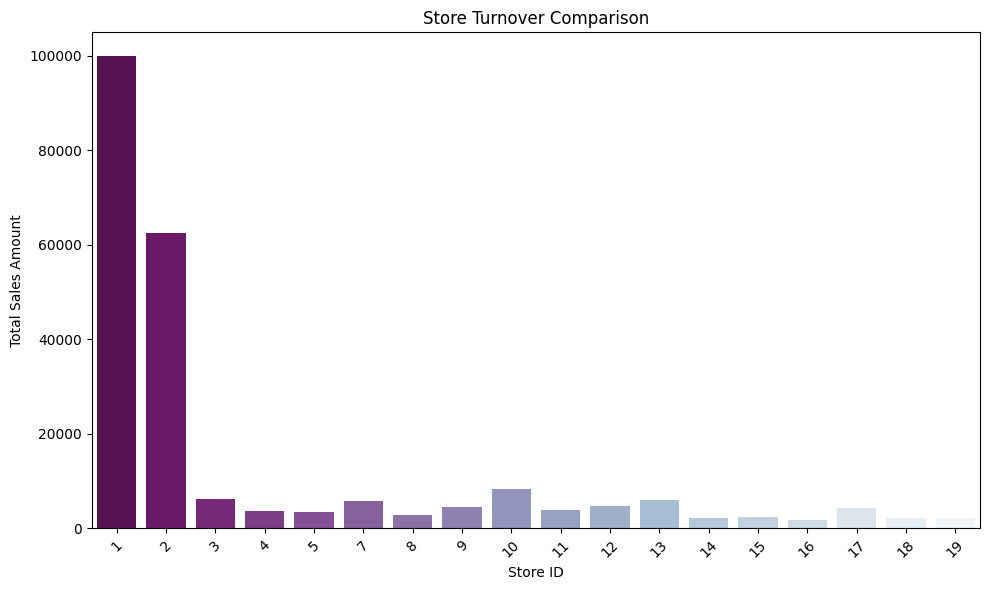

d_store_id          1.000000
sales_amount    99958.436377
Name: 0, dtype: float64

In [13]:
# Aggregation of sales amount by store to identify turnover
store_turnover = data_task1.groupby('d_store_id')['sales_amount'].sum().reset_index()

# Sorting stores by turnover for better visualization
store_turnover_sorted = store_turnover.sort_values('sales_amount', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='d_store_id', y='sales_amount', data=store_turnover_sorted, palette='BuPu_r')
plt.title('Store Turnover Comparison')
plt.xlabel('Store ID')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

# Identify the store with the highest turnover
top_store = store_turnover_sorted.iloc[0]

top_store

**Findings**
- The visualization above shows the comparison of turnover across different stores in the dataset.
- Store ID 1 emerges as the top performer, with the highest total sales amount, significantly leading over the others.

**Insights**
- The dominant performance of Store ID 1 suggests it might be located in a high traffic area or offers a product mix that's particularly appealing to customers.
- Understanding the factors behind this store's success could provide valuable insights for replicating its success in other locations.

**Next Steps**
- Investigate the characteristics of Store ID 1, such as location, size, product variety, and customer service quality, to identify key success factors.
- Explore the possibility of applying successful strategies from Store ID 1 to other stores to boost their performance.

#### 1.2. - Analysis of Frequent Item Combinations

In [19]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# data prep: create a list of transactions, where each transaction is a list of items (d_global_item_id) bought together
transactions = data_task1.groupby('bon_id_int')['d_global_item_id'].apply(list).tolist()

# Initialize the TransactionEncoder, which transforms the data into a format suitable for the Apriori algorithm
encoder = TransactionEncoder()
transactions_encoded = encoder.fit_transform(transactions)
transactions_df = pd.DataFrame(transactions_encoded, columns=encoder.columns_)

# Apply the Apriori algorithm to find frequent itemsets with a minimum support threshold
# Note: The support threshold is set very low due to the small dataset
frequent_itemsets = apriori(transactions_df, min_support=0.001, use_colnames=True) # tried min_support=0.01 -> empty dataframe

# Filter the frequent itemsets to find sets of 3 items
frequent_itemsets_3 = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) == 3)]

# Sort the itemsets by support to find the most frequent combinations
frequent_itemsets_3_sorted = frequent_itemsets_3.sort_values('support', ascending=False).head()

print(frequent_itemsets_3_sorted.to_string())


,support,itemsets
1269,0.002825,"(5576, 6625, 33292)"
1263,0.002702,"(5576, 6625, 12666)"
1264,0.002375,"(12712, 6625, 5576)"
1266,0.002252,"(5576, 6625, 14758)"
1301,0.002088,"(125607, 125924, 125479)"


In [21]:
# Calculate the number of unique items in the dataset
num_unique_items = data_task1['d_global_item_id'].nunique()
num_unique_items

8634

**Findings**   
After adjusting the min_support to a lower threshold of 0.001, we've successfully identified the most frequent combination of 3 items within the transactions is...

Items (5576, 6625, 33292) with a support of 0.002825


**Interpretation**   
The support value represents the proportion of transactions in the dataset that include the itemset. Here, a support of 0.002825 for the first itemset means that this combination of items appears in 0.2825% of all transactions.

The listed combinations are the ones most frequently purchased together, although the occurrence is relatively rare given the low support values. This is indicative of either a dataset with a large variety of items or transactions that generally contain a diverse set of items. Our dataset contains *8,634 unique items*. This large variety could be the reason why we initially observed no frequent itemsets at a higher support threshold and had to lower it to 0.001 to find common combinations of three items.

**Implications**    
Such information can be crucial for strategic decisions such as store layout optimization, targeted promotions, and inventory management. Understanding these combinations can help the supermarket chain to cross-promote products or offer bundle deals to increase sales.

**Threshold Interpretation**   
A min_support threshold of 0.001 means that we are only considering itemsets that appear in at least 0.1% of all transactions. This threshold is chosen to capture even those itemsets that occur infrequently, which is particularly useful in datasets with a wide variety of items and low individual item frequency. 

#### 1.3 Probability Analysis for Items 115677 and 84872

In [22]:
# Define the item IDs for the items of interest
item_A = 115677
item_B = 84872

# Calculate the number of transactions containing item A
transactions_with_A = data_task1[data_task1['d_global_item_id'] == item_A]['bon_id_int'].nunique()

# Calculate the number of transactions containing both items A and B
transactions_with_both = data_task1[(data_task1['d_global_item_id'] == item_A) & 
                                    (data_task1['bon_id_int'].isin(data_task1[data_task1['d_global_item_id'] == item_B]['bon_id_int']))]['bon_id_int'].nunique()

# Calculate the overall number of transactions
total_transactions = data_task1['bon_id_int'].nunique()

# Calculate the individual probabilities
prob_A = transactions_with_A / total_transactions
prob_B_given_A = transactions_with_both / transactions_with_A

(prob_A, prob_B_given_A)


(0.0015147793334970932, 0.8108108108108109)

**Calculations**
- The probability of purchasing item 115677 (`prob_A`) is approximately 0.151%.
- The conditional probability of purchasing item 84872 given that item 115677 has been purchased (`prob_B_given_A`) is approximately 81.08%.


**Interpretation**    
The findings suggest a very strong association between the purchase of item 115677 and item 84872. When item 115677 is bought, there is an 81.08% chance that item 84872 is also purchased within the same transaction.

This high conditional probability indicates that the two items are likely to be purchased together far more often than what would be expected if they were independent, given that the individual probability of purchasing item 115677 is only 0.151%.


**Insights**   
- This could imply that there is a strong complementary relationship between the two items, such as being used together or being part of a common set of items that customers tend to buy in one go.
- The supermarket might consider this when thinking about product placement, potentially placing these items closer to one another to increase the convenience for customers and potentially drive up sales for both items.

**Statistical Significance**   
While the conditional probability is high, it would be prudent to conduct a statistical test, such as the chi-square test for independence, to confirm that this association is statistically significant and not due to random chance in the dataset.

In [23]:
from scipy.stats import chi2_contingency

# Create the contingency table
# Count the number of transactions where neither, either, or both items were bought
neither = data_task1[~data_task1['bon_id_int'].isin(data_task1[data_task1['d_global_item_id'].isin([item_A, item_B])]['bon_id_int'])]['bon_id_int'].nunique()
item_A_only = transactions_with_A - transactions_with_both
item_B_only = data_task1[data_task1['d_global_item_id'] == item_B]['bon_id_int'].nunique() - transactions_with_both
both_items = transactions_with_both

contingency_table = [
    [item_A_only, item_B_only],  # Only A, Only B
    [both_items, neither]        # Both A and B, Neither A nor B
]

# Perform the chi-square test
chi2, p, dof, ex = chi2_contingency(contingency_table)

chi2, p, dof, ex


(1202.6765671006374,
 1.598111124714669e-263,
 1,
 array([[3.48399247e-02, 2.29651601e+01],
        [3.69651601e+01, 2.43660348e+04]]))

**Test Statistics**   
Chi-Square Value: 1202.68
Degrees of Freedom: 1
p-value: Approximately 1.60e-263

**Interpretation**    
The Chi-Square test provides a p-value that is significantly lower than any conventional significance level (e.g., 0.05, 0.01). This extremely low p-value indicates that we can reject the null hypothesis of independence.

**Conclusion**     
There is a statistically significant association between the purchase of item 115677 and item 84872. The likelihood of purchasing item 84872 given that item 115677 has already been purchased is not due to chance, and the two items have a strong positive association in the context of customer purchasing patterns.

**Implications**    
Given this significant result, the supermarket chain may consider strategies that leverage this association, such as:

- Joint promotions or discounts when both items are purchased together.
- Strategic product placement in stores to facilitate the purchase of both items.
- Inventory management practices that ensure both items are stocked in proportion to their joint sales potential.
- This insight can be a valuable asset in increasing sales and customer satisfaction through better understanding of shopping behavior.

## Task 2 - Data Wrangling

You are provided with extracts from two datasets in `data_task2_extract_1.csv` and `data_task2_extract_2.csv`, containing company information. 

The first dataset has standardized publically available information obtained via web scrapping, the second dataset contains confidential internal company information. 

In full, the datasets contain tens of thousands of observations so manual processing is not feasible. The task at hand is to match the data items between the two datasets as best as possible. The primary matching criteria is Address (identified by fields **Address Name**, **City** and **PostCode**). However, address fields are often inputted by humans, thus conventions vary widely. 

Please prepare an automated approach for canonicalization. Your code should handle discrepancies such as representing *Strasse* in full or shortened (*Str.*). The algorithm need not handle for all possible discrepancies, as this is hard to implement without the full data, description of an iterative procedure is sufficient.

**Bonus** - One company might appear with different addresses. Imagine the company building / offices are at an intersection and the company records contain registration on each of the two intersecting streets, i.e. addresses are different. Please formulate an approach to handle for such cases. Sample implementation will yield more points.

### Solution Ramon

In [34]:
# import (additional) libraries for task 2
from thefuzz import fuzz # for developing similarity score

#### 2.0 Perliminary Analysis

Again, before we start diving into the task, lets get a quick overview of the data

In [28]:
# Load the datasets for Task 2
data_task2_extract_1_path = 'data/data_task2_extract_1.csv'
data_task2_extract_2_path = 'data/data_task2_extract_2.csv'

# Loading the datasets
data_task2_extract_1 = pd.read_csv(data_task2_extract_1_path)
data_task2_extract_2 = pd.read_csv(data_task2_extract_2_path)

# Display the first few rows of each dataframe to understand their structure
preview_extract_1 = data_task2_extract_1.head()
preview_extract_2 = data_task2_extract_2.head()

print("preview extract 1: ", preview_extract_1)
print("*"*90)
print("preview extract 2: ", preview_extract_2)


preview extract 1:                       Company.Name             Address        City Postcode
0                    Carsten Helm         Ulmenstr. 8      Wismar    23966
1  Zirpel & Pautzsch Ingenieur Pa    Paditzer Str. 33   Altenburg     4600
2                 Eberhard Zessin   Steingartenweg 12  Heidelberg    69118
3                    Gerold Fuchs          Mühlweg 12   Dietingen    78661
4                 Rudi Biedritzky  Zaisentalstr. 70/1  Reutlingen    72760
******************************************************************************************
preview extract 2:                                           Address Postal.Code  \
0                           Alfons-Müller-Platz        50389   
1                                  Hauptstr. 10B       66459   
2                                  Edisonstr. 36       04435   
3  Kutterstr. 3 / 26386 Wilhelmshaven-Rüstersiel       26386   
4                               Am neuen Markt 8       66877   

              Location  
0        

In [44]:
print(data_task2_extract_1.describe())
print("*"*50)
print(data_task2_extract_2.describe())

       Company.Name       Address    City Postcode
count          5412          5328    5321     5324
unique         5378          5205    2407     3296
top           17489  bahnhofstr 4  berlin    28203
freq              4             5     227        8
**************************************************
               Address Postcode     City
count              222      214      221
unique             221      203      181
top     rathausplatz 1    24837  hamburg
freq                 2        3        6


**Dataset 1 Overview**   
- Contains columns for Company.Name, Address, City, and Postcode.
- The structure suggests detailed company information along with their address.

**Dataset 2 Overview**   
- Includes Address, Postal.Code, and Location.
- The columns are similar to those in Dataset 1 but with slightly different naming conventions (Postal.Code and Location).

No we are ready to proceed with the steps outlined for Task 2. Our focus will be on preparing the datasets for matching by standardizing and normalizing the address information.

**2.1 Data Cleaning and Standardization**    
First, we'll align the column names across the two datasets to ensure consistency, making it easier to compare and match records.

Further, we'll standardize the address formats by applying common corrections such as:

- Converting all text to lowercase for uniformity.
- Removing punctuation and special characters.
- Replacing common abbreviations (e.g., "Str." with "Straße") to ensure consistency.

**2.2 Developing the Automated Matching Algorithm**    
While the implementation details might be complex, the conceptual approach involves:

- Calculating similarity scores between address components of the two datasets.
- Setting a threshold for matching scores to determine when records are considered a match.

**2.3 Implementation**
This approach will require implementation, testing, and refinement on the local Python environment.

#### 2.1 Data Cleaning and Standardization

In [31]:
# Step 1: Standardize Column Names for Dataset 2 to match Dataset 1
data_task2_extract_2.rename(columns={'Postal.Code': 'Postcode', 'Location': 'City'}, inplace=True)

# Step 2: Normalize Addresses for both datasets
# Convert to lowercase, remove punctuation/special characters, and replace common abbreviations
for df in [data_task2_extract_1, data_task2_extract_2]:
    df['Address'] = df['Address'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
    df['City'] = df['City'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
    df['Postcode'] = df['Postcode'].str.replace(' ', '')  # Remove spaces in postcodes for uniformity

# Display the first few rows of each dataframe to verify changes
preview_cleaned_extract_1 = data_task2_extract_1.head()
preview_cleaned_extract_2 = data_task2_extract_2.head()

print("preview cleaned extract 1: ", preview_cleaned_extract_1)
print("*"*90)
print("preview cleaned extract 2: ", preview_cleaned_extract_2)


preview cleaned extract 1:                       Company.Name            Address        City Postcode
0                    Carsten Helm         ulmenstr 8      wismar    23966
1  Zirpel & Pautzsch Ingenieur Pa    paditzer str 33   altenburg     4600
2                 Eberhard Zessin  steingartenweg 12  heidelberg    69118
3                    Gerold Fuchs         mühlweg 12   dietingen    78661
4                 Rudi Biedritzky   zaisentalstr 701  reutlingen    72760
******************************************************************************************
preview cleaned extract 2:                                        Address Postcode                City
0                          alfonsmüllerplatz     50389           wesseling
1                                hauptstr 10b    66459              kirkel
2                                edisonstr 36    04435          schkeuditz
3  kutterstr 3  26386 wilhelmshavenrüstersiel    26386       wilhelmshaven
4                            am ne

The address information in both datasets has been standardized as follows:

- **Addresses** are converted to lowercase, punctuation and special characters are removed, and common abbreviations are standardized.
- **City names** are also standardized by converting to lowercase and removing punctuation.
- **Postcodes** have had spaces removed for uniformity.

**Dataset 1 Preview (Cleaned)**   
Addresses, city names, and postcodes have been normalized, e.g., "Ulmenstr. 8" to "ulmenstr 8".

**Dataset 2 Preview (Cleaned)**  
Similar normalization has been applied, including removing spaces in postcodes and addressing inconsistencies in address representation.

#### 2.2 Developing the Automated Matching Algorithmn

First, we utulize a fuzzy matching library in order to calculate similarity scores for each component of the addres between the two datasets.

In [50]:
# Define the function to calculate combined similarity score
def calculate_similarity(address1, address2, city1, city2, postcode1, postcode2):
    address_score = fuzz.ratio(address1, address2)
    city_score = fuzz.ratio(city1, city2)
    postcode_score = fuzz.ratio(postcode1, postcode2)
    combined_score = (address_score + city_score + postcode_score) / 3
    return combined_score

By calculating a combined similarity score, we can better identify true matches, especially in cases where one attribute might slightly differ but the overall context suggests a strong match. This approach is particularly useful for datasets where minor discrepancies might exist due to variations in data entry or updates to address information over time.

In [52]:
best_matches = []

# Iterate through the rows of the first dataset
for index1, row1 in data_task2_extract_1.iterrows():
    best_score = 0
    best_match_index = None
    
    # Pre-selection by city for efficiency
    potential_matches = data_task2_extract_2[data_task2_extract_2['City'] == row1['City']]
    
    for index2, row2 in potential_matches.iterrows():
        # Calculate the combined similarity score
        score = calculate_similarity(row1['Address'], row2['Address'], 
                                     row1['City'], row2['City'], 
                                     row1['Postcode'], row2['Postcode'])
        
        if score > best_score:
            best_score = score
            best_match_index = index2
    
    if best_match_index is not None:
        best_matches.append((index1, best_match_index, best_score))

# Optionally print or process the best matches
for match in best_matches:
    index1, index2, score = match
    print(f"Match Score: {score}")
    print("Dataset 1 Entry:")
    print(data_task2_extract_1.iloc[index1])
    print("Dataset 2 Entry:")
    print(data_task2_extract_2.iloc[index2])
    print("-"*60)

Match Score: 74.66666666666667
Dataset 1 Entry:
Company.Name    Matthias Essers GmbH Elektrote
Address                     leopoldhoeschstr 4
City                             geilenkirchen
Postcode                                 52511
Name: 7, dtype: object
Dataset 2 Entry:
Address     camphausenweg 8
Postcode              52511
City          geilenkirchen
Name: 71, dtype: object
------------------------------------------------------------
Match Score: 66.0
Dataset 1 Entry:
Company.Name    Hartmut Münchow
Address          kamillenweg 29
City                    leipzig
Postcode                   4158
Name: 19, dtype: object
Dataset 2 Entry:
Address     am sportforum 3  04105 leipzig
Postcode                              4105
City                               leipzig
Name: 73, dtype: object
------------------------------------------------------------
Match Score: 82.66666666666667
Dataset 1 Entry:
Company.Name    Poelzig Architekten GmbH
Address                     menzelstr 56
City   

**Pre-Selection**   
Before performing detailed similarity calculations, we filter potential matches within the same city, since that is easy to compute.

**Defining a Useful Threshold**    
The choice of threshold can significantly impact the number of matches found, as well as the false positive and false negative rates. A common starting point for fuzzy matching is to set a threshold around 80-85 for fields that need to be very similar (like addresses), and perhaps a bit lower for fields where minor variations are more common (like company names).

However, the optimal threshold may vary depending on the data and the specific fields being matched. We start with a conservative threshold that minimizes false positives and then adjust based on a review of the results (future step).

In [48]:
matches1 = []  

# Iterate through the rows of the first dataset
for index1, row1 in data_task2_extract_1.iterrows():
    # Pre-selection by city 
    potential_matches = data_task2_extract_2[data_task2_extract_2['City'] == row1['City']]
    
    for index2, row2 in potential_matches.iterrows():
        # Calculate similarity score for addresses within the same city
        score = fuzz.ratio(row1['Address'], row2['Address'])
        
        if score >= 85:  # Assuming a threshold of 85 for address similarity
            matches1.append((index1, index2, score))

matches1
# This results in a list of tuples, where each tuple contains the index of the matching entries in df1 and df2, and their similarity score


[(428, 180, 96),
 (1654, 108, 86),
 (1695, 45, 85),
 (1766, 34, 100),
 (1935, 186, 93),
 (2433, 107, 100),
 (2690, 19, 95),
 (2885, 212, 94),
 (4114, 11, 100),
 (4126, 198, 90),
 (5396, 92, 100)]

In [49]:
# For each match, print the corresponding entries from both datasets for comparison
for match in matches:
    index1, index2, score = match
    
    # Extract matched rows from both datasets
    row_df1 = data_task2_extract_1.iloc[index1]
    row_df2 = data_task2_extract_2.iloc[index2]
    
    # Print the match details for comparison
    print(f"Match Score: {score}")
    print("Dataset 1 Entry:")
    print(f"Company Name: {row_df1['Company.Name']}")
    print(f"Address: {row_df1['Address']}, City: {row_df1['City']}, Postcode: {row_df1['Postcode']}")
    print("Dataset 2 Entry:")
    print(f"Address: {row_df2['Address']}, City: {row_df2['City']}, Postcode: {row_df2['Postcode']}")
    print("-"*60)


Match Score: 96
Dataset 1 Entry:
Company Name: Elektro - Horstmann Werner Hor
Address: bramfelder chaussee 305, City: hamburg, Postcode: 22177
Dataset 2 Entry:
Address: bramfelder chaussee 130, City: hamburg, Postcode: 22177
------------------------------------------------------------
Match Score: 86
Dataset 1 Entry:
Company Name: ELektro Schramm GmbH
Address: landshuter str 101, City: ergolding, Postcode: 84030
Dataset 2 Entry:
Address: landshuter str 65, City: ergolding, Postcode: 84030
------------------------------------------------------------
Match Score: 85
Dataset 1 Entry:
Company Name: Elektro Hans Anspach jun. Gese
Address: koblenzer str 79, City: koblenz, Postcode: 56073
Dataset 2 Entry:
Address: koblenzer str 115, City: koblenz, Postcode: 56073
------------------------------------------------------------
Match Score: 100
Dataset 1 Entry:
Company Name: elektro-braun Mechernich GmbH
Address: weierstr 54, City: mechernich, Postcode: 53894
Dataset 2 Entry:
Address: weierstr 54,

...

## Task 3 - Data  Modelling

You are provided with a small-scale survey data investigating grocery purchasing behaviour and habits of Croatians. First, please review the enclosed pdf file. This is the survey questionnaire describing all key information on how data had been gathered and each interview conducted.

The task at hand is to cluster the respondents in relatively homogenous groups. Start with all informative variables in the dataset. If you deem it necessary, you may create any number of additional derivative variables or include of publically available data. In case, your classification is based on specific subset of variables, please clearly describe why and how you have arrived at precisely this subset.

Write up: as clearly as possible please describe the procedure you have applied, the results and the insights you would draw from the segmentation. Parameter selection must be justified. The write-up should not exceed one page, 1.5-spaced, Arial, 12pts, standard margins.

### Solution Ramon

In [ ]:
# import (additional) libraries for task 3
from sklearn.cluster import KMeans # for clustering
from sklearn.preprocessing import StandardScaler # for scaling the data
from sklearn.decomposition import PCA # for dimensionality reduction


#### 3.0 Preliminary Analysis

In [57]:
# Data Loading
data_task3_path = 'data/data_task3.csv'
survey_data = pd.read_csv(data_task3_path)

# initial exploration
preview_task3 = survey_data.head()
structure_task3 = survey_data.dtypes
info_task3 = survey_data.info()

print("preview task 3: ", preview_task3)
print("*"*90)   
print("structure task 3: ", structure_task3)   
print("*"*90)
print("info task 3: ", info_task3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 569 entries, respid to q21_final
dtypes: float64(52), int64(31), object(486)
memory usage: 4.3+ MB
preview task 3:     respid                                             status    q1  q2   hage  \
0     424  complete                                      ...  male  33  30-34   
1     263  complete                                      ...  male  27  25-29   
2     142  complete                                      ...  male  32  30-34   
3     262  complete                                      ...  male  46  45-50   
4    1187  complete                                      ...  male  47  45-50   

    q3                   q4x1                q4x2                   q4x3  \
0  yes  once a couple of days                 NaN                  daily   
1  yes   once or twice a week               daily     once in 1-3 months   
2  yes                  daily   once in 2-4 weeks  once a couple of days   
3  yes     

The dataset from Task 3 contains responses from a survey designed to understand grocery purchasing behavior among Croatian shoppers. With 1,000 entries and a wide array of 569 columns, it encompasses a rich and detailed set of data points, including:

- **Respondent IDs (respid)** Unique identifiers for each survey respondent.
- **Survey Status (status)** Indicates the completion status of each response.
- **Demographic Information** Includes gender (`q1`), age (`q2`), age group (`hage`), and other demographics.
- **Shopping Habits and Preferences** Captures detailed information on shopping frequency (`q3`, `q4x1` to `q4x4`), store choices, factors influencing store choice, and more, through a mix of numerical, categorical, and object (likely text and categorical) data types.

**Key Observations**
- **Diverse Data Types** The dataset features a mix of *float64* (52 columns), *int64* (31 columns), and *object* (486 columns) data types. This diversity indicates a combination of numerical ratings or scores, categorical choices (e.g., frequency of shopping, types of products purchased), and possibly open-ended responses.
- **Complexity and Richness** With 569 columns, the dataset likely covers a broad range of questions from the survey, reflecting the complexity and richness of consumer behavior and preferences.
- **Preprocessing Needs** The prevalence of object data types suggests a significant need for data preprocessing, including encoding categorical variables for analysis and handling any missing or incomplete responses.
- **Potential for Insightful Analysis** The dataset's breadth and depth offer a substantial opportunity to segment Croatian grocery shoppers into meaningful clusters based on their responses. These clusters can reveal distinct patterns in shopping behavior, preferences, and demographic profiles.

#### 3.1 Data Preparation for Cluster Analysis

Before conducting the Cluster Analysis, we need to do some data preparation. This phase is crucial for ensuring the quality and effectiveness of clustering analysis and involves cleaning the data, handling missing values, encoding categorical variables, and normalizing numerical variables.

Regarding the missing values, I consider imputating them with the median for numerical variables and a placeholder 'Unknown' for categorical variables.

In [61]:
# numerical variables
numerical_cols = survey_data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    survey_data[col] = survey_data[col].fillna(survey_data[col].median())

# categorical variables with placeholder 'Unknown'
categorical_cols = survey_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    survey_data[col] = survey_data[col].fillna('Unknown')




For categorical variables without a natural order (nominal variables), one-hot encoding is a common approach that creates binary columns for each category.

In [90]:
categorical_cols = survey_data.select_dtypes(include=['object']).columns.tolist()

# Applying one-hot encoding to the categorical columns
survey_data_encoded = pd.get_dummies(survey_data, columns=categorical_cols)

print(survey_data_encoded.head())


   respid  q2    q5  q6_1  q6_2  q6_3  q6_4  q9_1  q9_2  q9_3  ...  \
0     424  33  1500    80  20.0  20.0   5.0   7.0   8.0   1.0  ...   
1     263  27  3000    60  30.0   5.0   5.0   6.0   5.0   2.0  ...   
2     142  32  1500    80  10.0  10.0   0.0   5.0   2.0   1.0  ...   
3     262  46  1500    65   5.0  25.0   5.0   6.0   2.0   4.0  ...   
4    1187  47  2000    95   2.0   3.0   5.0   5.0  12.0   6.0  ...   

   q28_15 001 - 20 000 HRK  q28_20 001 - 25 000 HRK  q28_25 001 - 30 000 HRK  \
0                    False                    False                    False   
1                    False                    False                    False   
2                    False                    False                    False   
3                    False                    False                    False   
4                    False                    False                    False   

   q28_5 000 - 10 000 HRK  q28_I prefer not to say  q28_less than 5000 HRK  \
0                   

The dataset now includes a wide range of encoded features, significantly expanding the number of columns from the original set to 2,366. This transformation is largely due to the one-hot encoding of categorical variables, which creates a separate column for each category within a variable.

- **Original Dataset Structure** The dataset began with a mix of numerical and categorical variables, capturing various aspects of shoppers' preferences, behaviors, and demographics.
- **Encoding Categorical Variables** Categorical variables have been one-hot encoded, resulting in a significant increase in the dataset's dimensionality. This encoding process transforms categorical variables into a format that machine learning algorithms can work with, by creating binary (0 or 1) columns for each category.
- **Handling Numerical Variables** Numerical variables such as `q2` (age) and `q5` (monthly spending) have been retained in their original form. These, along with the newly encoded features, provide a comprehensive numerical representation of the survey responses.
- **Expanded Feature Set** The dataset now includes a broad array of features, such as income ranges (`q28_5 000 - 10 000 HRK`, `q28_less than 5000 HRK`, etc.) and activity levels (`q21_final_2 to 4 activities`, `q21_final_5 and more activities`), each represented as binary indicators.

#### 3.2 Feature Selection

Based on the questionnaire, we'll select key features that are likely to influence shopping behavior:
We prioritize quantitative variables like `q2` (age) and `q5` (monthly spending) for demographic insights and spending behavior.
Categorical variables related to shopping frequency and preferences have been one-hot encoded. As a start, we select the monthly combined income of the household (`q28-er`)

In [74]:
selected_features = survey_data_encoded[[column for column in survey_data_encoded.columns if 'q2' in column or 'q5' in column or column.startswith('q4') or column.startswith('q8')]]

features_list = ['q2', 'q5', 'q28_less than 5000 HRK', 'q28_5 000 - 10 000 HRK', 'q28_10 001 - 15 000 HRK', 'q28_15 001 - 20 000 HRK', 
'q28_20 001 - 25 000 HRK', 'q28_25 001 - 30 000 HRK', 'q28_more than 30 000 HRK', 'q28_I prefer not to say'] 

selected_features = survey_data_encoded[features_list]

selected_features.head()


,q2,q5,q28_less than 5000 HRK,q28_5 000 - 10 000 HRK,q28_10 001 - 15 000 HRK,q28_15 001 - 20 000 HRK,q28_20 001 - 25 000 HRK,q28_25 001 - 30 000 HRK,q28_more than 30 000 HRK,q28_I prefer not to say
0,33,1500,True,False,False,False,False,False,False,False
1,27,3000,False,False,False,False,False,False,False,True
2,32,1500,False,False,True,False,False,False,False,False
3,46,1500,True,False,False,False,False,False,False,False
4,47,2000,False,True,False,False,False,False,False,False


#### 3.3 Cluster Analysis

In [95]:
# Standardize the selected features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # Adjust the number of clusters as necessary
clusters = kmeans.fit_predict(scaled_features)

# Append the cluster labels to your DataFrame
survey_data_encoded['Cluster'] = clusters

# Display the first few rows of the selected 
preview_with_clusters = survey_data_encoded.head()
preview_with_clusters

,respid,q2,q5,q6_1,q6_2,q6_3,q6_4,q9_1,q9_2,q9_3,...,q28_20 001 - 25 000 HRK,q28_25 001 - 30 000 HRK,q28_5 000 - 10 000 HRK,q28_I prefer not to say,q28_less than 5000 HRK,q28_more than 30 000 HRK,q21_final_2 to 4 activities,q21_final_5 and more activities,q21_final_Unknown,Cluster
0,424,33,1500,80,20.0,20.0,5.0,7.0,8.0,1.0,...,False,False,False,False,True,False,False,False,True,3
1,263,27,3000,60,30.0,5.0,5.0,6.0,5.0,2.0,...,False,False,False,True,False,False,False,True,False,1
2,142,32,1500,80,10.0,10.0,0.0,5.0,2.0,1.0,...,False,False,False,False,False,False,False,False,True,0
3,262,46,1500,65,5.0,25.0,5.0,6.0,2.0,4.0,...,False,False,False,False,True,False,True,False,False,3
4,1187,47,2000,95,2.0,3.0,5.0,5.0,12.0,6.0,...,False,False,True,False,False,False,False,False,True,0


In the final step of our analysis, we apply Principal Component Analysis (PCA) to visualize the clusters formed from our selected features, which include both quantitative variables like age (q2) and monthly spending (q5), and categorical variables related to shopping preferences that have been one-hot encoded, notably including the household's monthly combined income (q28-er). 

This visualization technique helps in understanding the distribution and separation of clusters in a reduced dimensional space, providing valuable insights into distinct shopper segments based on demographic insights, spending behavior, and income levels.

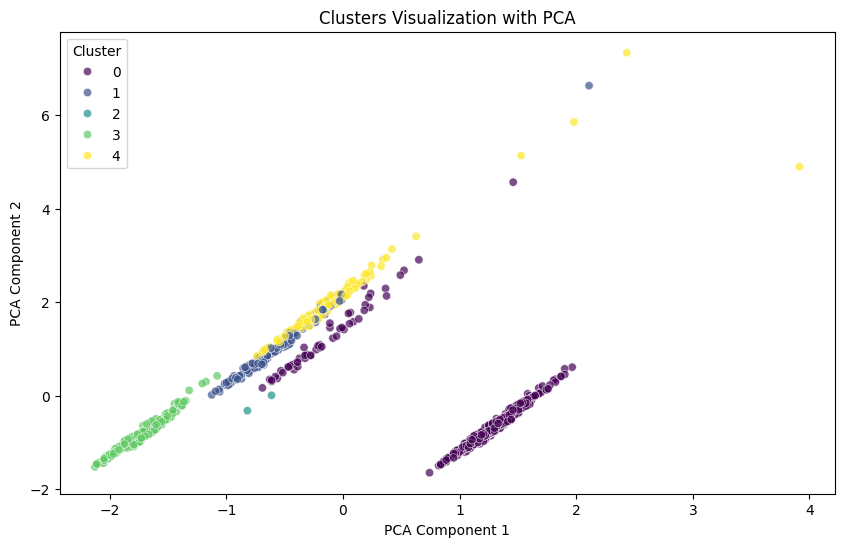

In [94]:
# Apply PCA to reduce the features to 2 components for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Plot the reduced features with cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_features[:,0], y=reduced_features[:,1], hue=clusters, palette='viridis', alpha=0.7)
plt.title('Clusters Visualization with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


The PCA scatter plot reveals the distribution of survey respondents across the first two principal components, segmented into five clusters. Each cluster likely encapsulates distinct shopper profiles based on features like age, monthly spending, and income brackets.

**Cluster 0 (Purple)** This cluster shows a tight grouping, possibly representing a segment with similar income levels or spending patterns.
**Cluster 1 (Green)** Spread along both components, this cluster may consist of respondents with a wide range of ages and incomes.
**Cluster 2 (Yellow)** Positioned distinctly along Component 1, indicating a unique characteristic, possibly a narrower age range or income level.
**Cluster 3 (Blue)** Exhibits medium variance in Component 1 and 2, suggesting moderate differences in spending habits or demographics.
**Cluster 4 (Orange)** This cluster is sparse and spread out, indicating greater diversity in the features or less cohesion in the profile traits.

This visual segmentation helps to understand the underlying structure of the data and the relationships between different shopper characteristics. However, to make precise statements about age ranges and spending habits, we would need to analyze the cluster centroids in relation to the original features.